In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Settings for plt & sns
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

#Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Inventory Optimization through Demand Forecasting/data/train.csv')

print(df.head())

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Cat

In [2]:
#General information of the DataFrame
print("\nDataFrame General Info:")
df.info()

print("\nDescriptive Statistics:")
df.describe()


DataFrame General Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-nul

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


In [3]:
#Data Cleaning and Formatting

df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

#Select the essentials for forecasting ---> Order Date' and 'Sales'
sales_df = df[['Order Date', 'Sales']]

sales_df = sales_df.sort_values('Order Date')

sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9800 entries, 7980 to 5091
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  9800 non-null   datetime64[ns]
 1   Sales       9800 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 229.7 KB


In [4]:
#Aggregate sales by month
#Set order date as the index to perform time based operations
sales_df = sales_df.set_index('Order Date')

#Resample the data to a monthly frequency ('MS' -> Calendar month start) and sum the sales
#The result will be the total sales for each month
monthly_sales = sales_df['Sales'].resample('MS').sum()

print("Top 5 rows of the aggregated monthly sales data:")
monthly_sales.head()

Top 5 rows of the aggregated monthly sales data:


,Sales
Order Date,
2015-01-01,14205.707
2015-02-01,4519.892
2015-03-01,55205.797
2015-04-01,27906.855
2015-05-01,23644.303


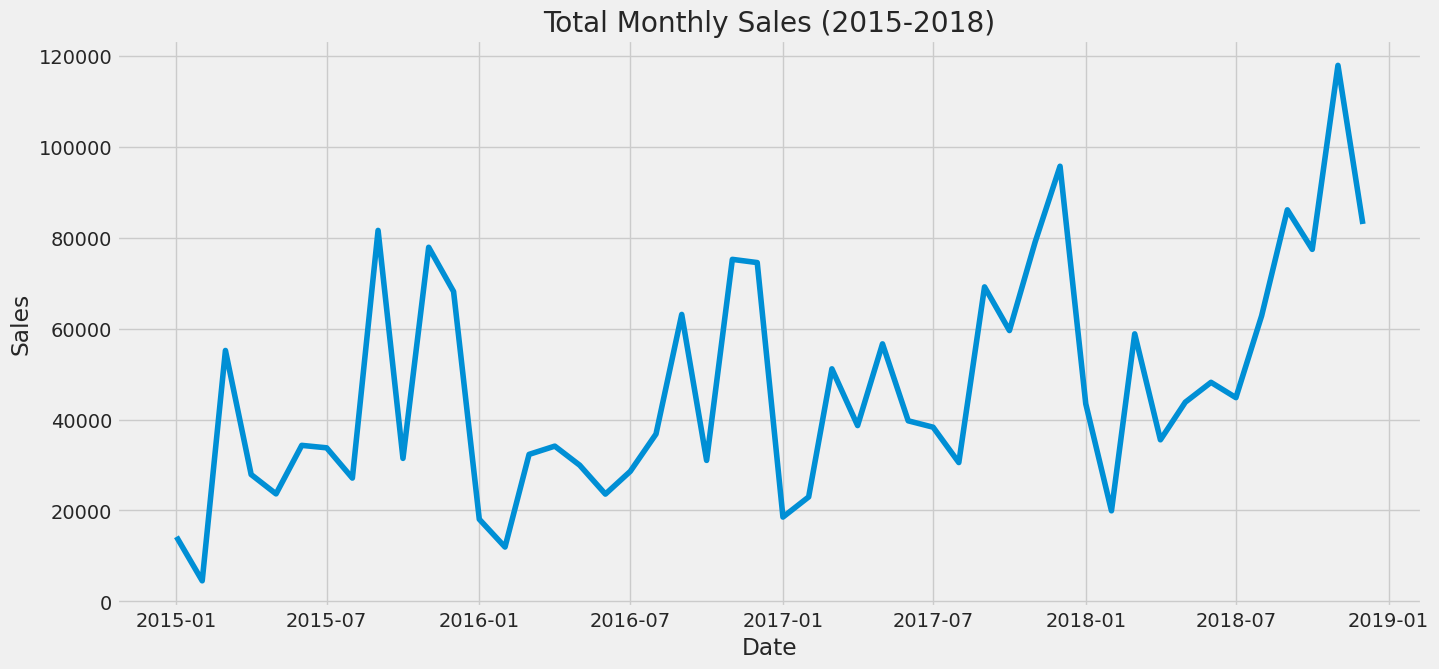

In [5]:
#Plotting the monthly sales data
plt.figure(figsize=(15, 7))
plt.plot(monthly_sales)
plt.title('Total Monthly Sales (2015-2018)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

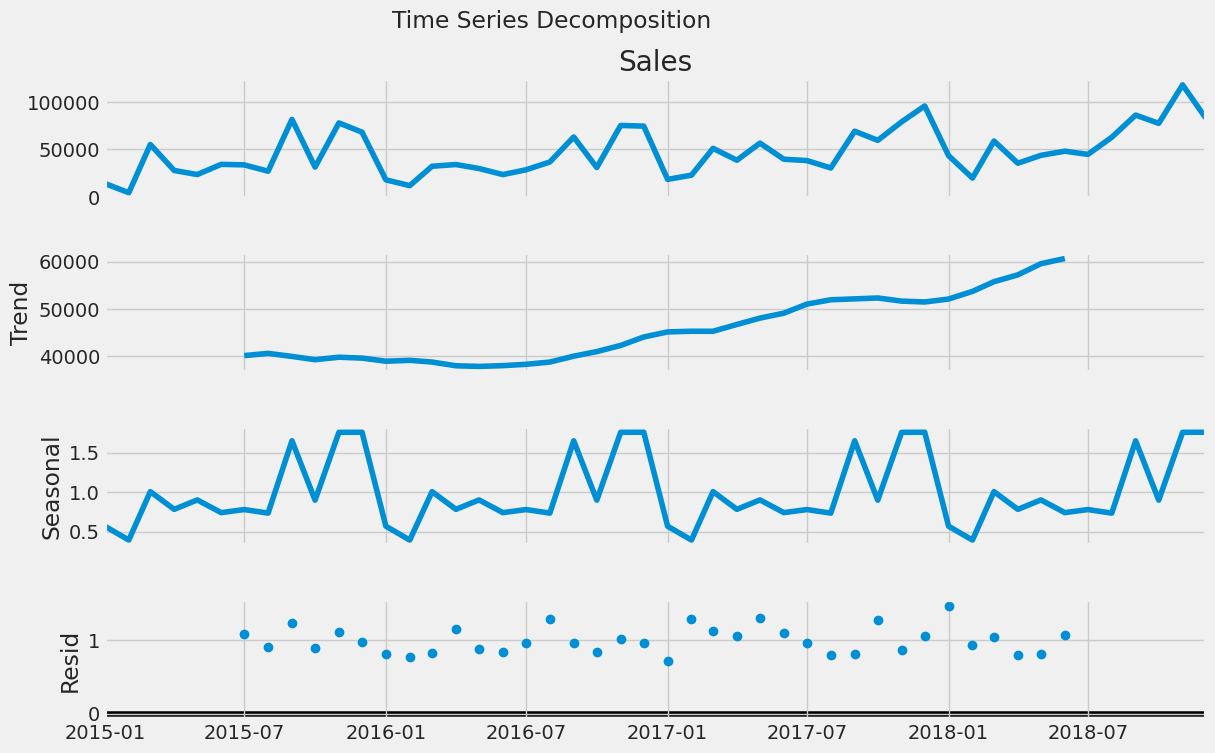

In [6]:
#Decomposing the time series
from statsmodels.tsa.seasonal import seasonal_decompose

#The best choice here is a multiplicative model because the seasonal fluctuations appear to grow with the trend
decomposition = seasonal_decompose(monthly_sales, model='multiplicative')

#Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.suptitle('Time Series Decomposition')
plt.show()

In [7]:
#Perform the Augmented Dickey-Fuller (ADF) test
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """
    Function to perform and interpret the ADF test.
    """
    result = adfuller(series, autolag='AIC')
    print('--- Augmented Dickey-Fuller Test ---')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    if result[1] <= 0.05:
        print("\nConclusion: Strong evidence against the null hypothesis. The series is likely stationary.")
    else:
        print("\nConclusion: Weak evidence against null hypothesis. The series is likely non-stationary.")

#Run the test on our monthly sales data
adf_test(monthly_sales)

--- Augmented Dickey-Fuller Test ---
ADF Statistic: -4.416136761430769
p-value: 0.00027791039276670623
Critical Values:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064

Conclusion: Strong evidence against the null hypothesis. The series is likely stationary.


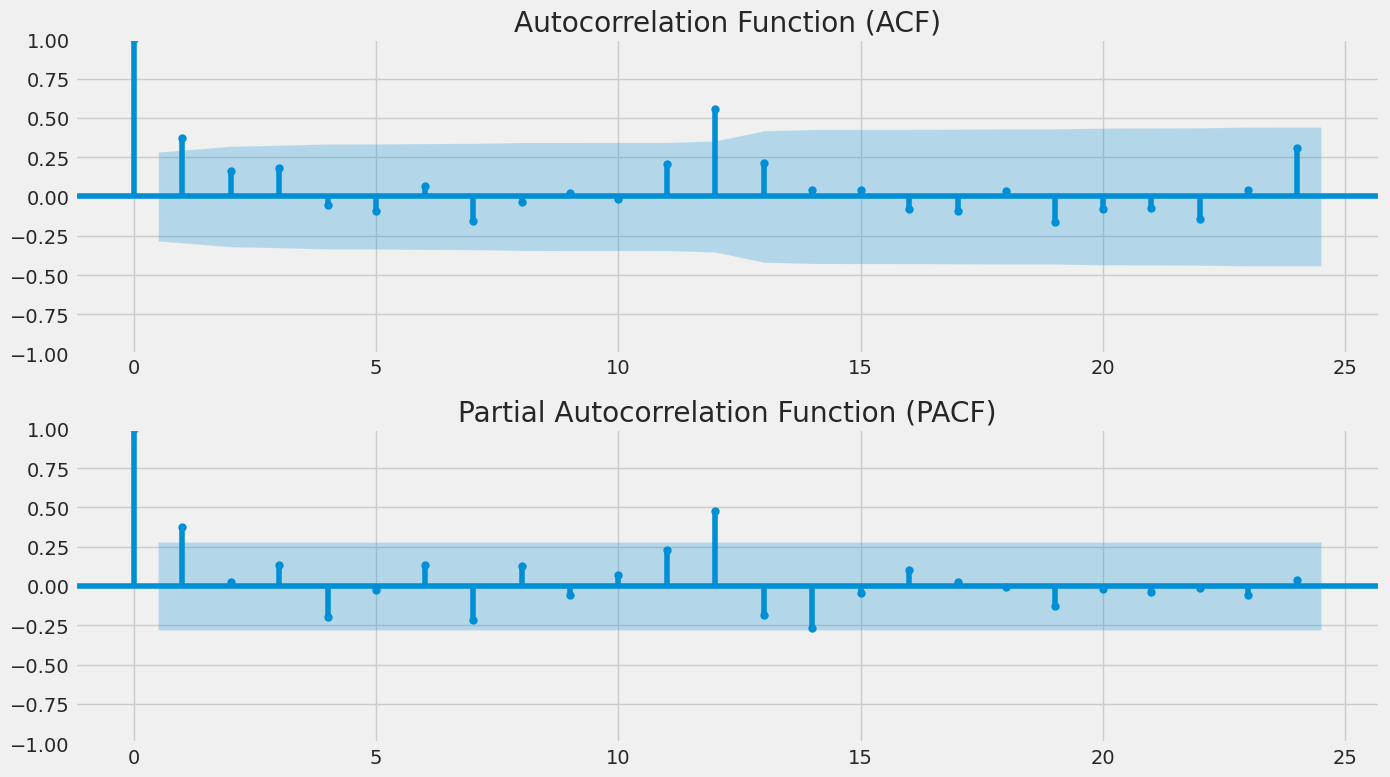

In [8]:
#Plot ACF and PACF to identify model parameters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Generate the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

#ACF plot
plot_acf(monthly_sales, ax=ax1, lags=24) # We plot up to 23 lags
ax1.set_title('Autocorrelation Function (ACF)')

#PACF plot
plot_pacf(monthly_sales, ax=ax2, lags=24) # We plot up to 23 lags
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Training data points: 36
Testing data points: 12


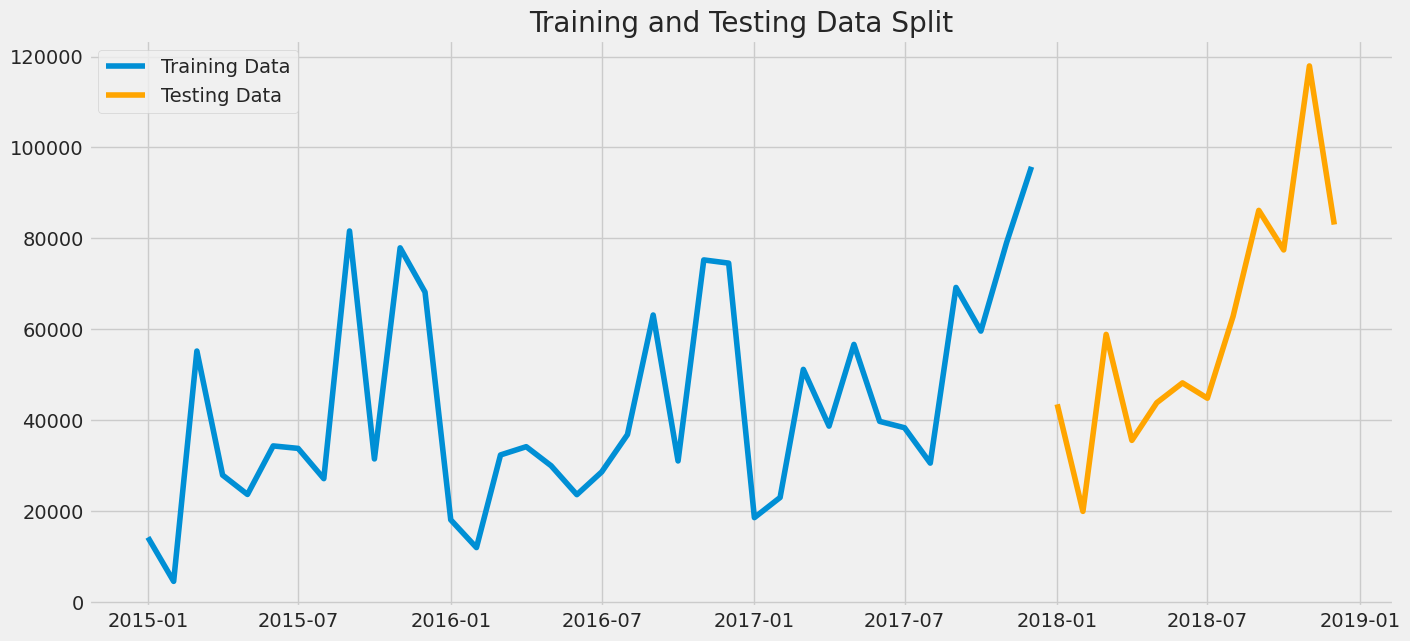

In [9]:
# Split data into training and testing sets
train_data = monthly_sales[monthly_sales.index < '2018-01-01']
test_data = monthly_sales[monthly_sales.index >= '2018-01-01']

print(f"Training data points: {len(train_data)}")
print(f"Testing data points: {len(test_data)}")

#Plot the split
plt.figure(figsize=(15, 7))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data', color='orange')
plt.title('Training and Testing Data Split')
plt.legend()
plt.show()

In [10]:
#Import the SARIMAX model from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Define and fit the model, using SARIMA(1, 0, 1)(2, 1, 1, 12) based on ACF/PACF and seasonal decomposition
model = SARIMAX(train_data,
                order=(1, 0, 1),
                seasonal_order=(1, 1, 0, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

#Fit the model and print the summary
results = model.fit()

print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   36
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood                -117.299
Date:                             Wed, 22 Oct 2025   AIC                            242.599
Time:                                     15:39:43   BIC                            244.190
Sample:                                 01-01-2015   HQIC                           241.596
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9936      0.089     11.172      0.000       0.819       1.168
ma.L1         -0.9881      

In [11]:
#Generate predictions for the test data period
predictions = results.get_prediction(start=pd.to_datetime('2018-01-01'), end=pd.to_datetime('2018-12-01'), dynamic=False)

#Confidence intervals for the predictions
pred_ci = predictions.conf_int()

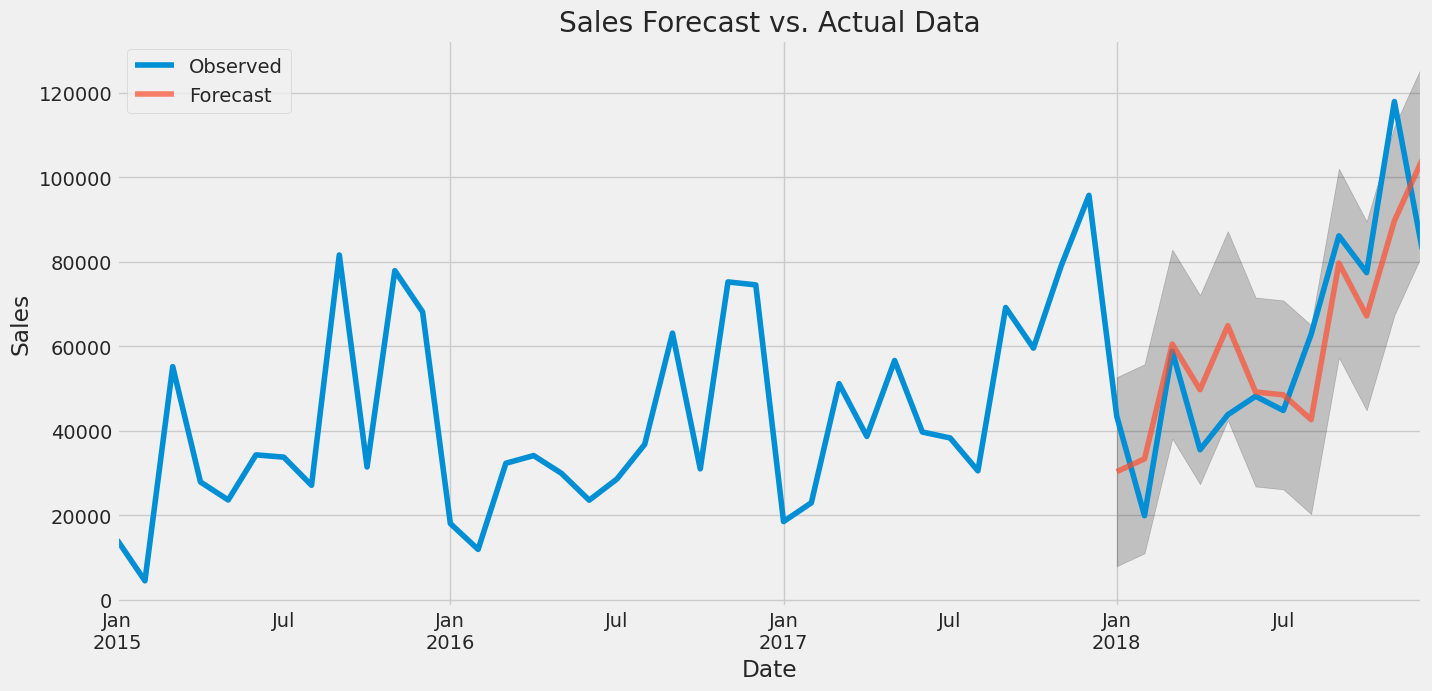

Root Mean Squared Error (RMSE): 15309.69


In [12]:
#Plot the real vs. predicted values
ax = monthly_sales['2015':].plot(label='Observed', figsize=(15, 7))
predictions.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

#Fill the area between the confidence intervals
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Sales Forecast vs. Actual Data')
plt.legend()
plt.show()

#Calculate and print the model's performance metric (RMSE)
from sklearn.metrics import mean_squared_error
import numpy as np

y_forecasted = predictions.predicted_mean
y_truth = test_data

#Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_truth, y_forecasted))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')